In [13]:
import duckdb
import pandas as pd

# Load CSVs into DuckDB (paths are raw strings to avoid unicodeescape issues)
movies_path = r'C:\Users\marti\OneDrive\Documentos\IMS_EDSA\B.D.F\ml-latest-small\movies.csv'
ratings_path = r'C:\Users\marti\OneDrive\Documentos\IMS_EDSA\B.D.F\ml-latest-small\ratings.csv'
links_path = r'C:\Users\marti\OneDrive\Documentos\IMS_EDSA\B.D.F\ml-latest-small\links.csv'
tags_path = r'C:\Users\marti\OneDrive\Documentos\IMS_EDSA\B.D.F\ml-latest-small\tags.csv'
duckdb.sql(f"CREATE OR REPLACE TABLE movies AS SELECT * FROM read_csv_auto('{movies_path}')")
duckdb.sql(f"CREATE OR REPLACE TABLE ratings AS SELECT * FROM read_csv_auto('{ratings_path}')")
duckdb.sql(f"CREATE OR REPLACE TABLE links AS SELECT * FROM read_csv_auto('{links_path}')")
duckdb.sql(f"CREATE OR REPLACE TABLE tags AS SELECT * FROM read_csv_auto('{tags_path}')")



In [ ]:
# Mostrar tabelas existentes
print("Tabelas disponíveis:")
print(duckdb.sql("SHOW TABLES").df())

# Opcional: ver primeiras linhas de cada tabela
for tbl in ["movies", "ratings", "links", "tags"]:
    print(f"\nPrimeiras linhas de {tbl}:")
    display(duckdb.sql(f"SELECT * FROM {tbl} LIMIT 5").df())


Tabelas disponíveis:
      name
0    links
1   movies
2  ratings
3     tags

Primeiras linhas de movies:


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy



Primeiras linhas de ratings:


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931



Primeiras linhas de links:


,movieId,imdbId,tmdbId
0,1,0114709,862
1,2,0113497,8844
2,3,0113228,15602
3,4,0114885,31357
4,5,0113041,11862



Primeiras linhas de tags:


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [11]:
# 1) Movie genres (unique)
genres_df = duckdb.sql("SELECT movieId, title, genres FROM movies").to_df()
genres_exploded = genres_df.assign(genres=genres_df.genres.str.split('|')).explode('genres')
unique_genres = sorted(genres_exploded['genres'].dropna().unique())
print('Movie genres (unique):')
print(unique_genres)

Movie genres (unique):
['(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


In [12]:
# 2) Number of movies per genre
movies_per_genre = genres_exploded.groupby('genres').movieId.nunique().reset_index(name='movie_count').sort_values('movie_count', ascending=False)
print('Number of movies per genre:')
print(movies_per_genre)

Number of movies per genre:
                genres  movie_count
8                Drama         4361
5               Comedy         3756
17            Thriller         1894
1               Action         1828
15             Romance         1596
2            Adventure         1263
6                Crime         1199
16              Sci-Fi          980
11              Horror          978
9              Fantasy          779
4             Children          664
3            Animation          611
14             Mystery          573
7          Documentary          440
18                 War          382
13             Musical          334
19             Western          167
12                IMAX          158
10           Film-Noir           87
0   (no genres listed)           34


In [13]:
# 3) Movie rating distribution per user (summary stats)
ratings_df = duckdb.sql("SELECT userId, movieId, rating, timestamp FROM ratings").to_df()
user_rating_counts = ratings_df.groupby('userId').rating.agg(['count','mean','std','min','max']).reset_index().rename(columns={'count':'ratings_count','mean':'ratings_mean','std':'ratings_std','min':'ratings_min','max':'ratings_max'})
print('Per-user rating distribution summary (first 10 users):')
print(user_rating_counts.head(10))
ratings_count_dist = user_rating_counts.ratings_count.value_counts().sort_index()
print('Distribution of number of ratings per user (ratings_count -> number of users):')
print(ratings_count_dist.head(20))

Per-user rating distribution summary (first 10 users):
   userId  ratings_count  ratings_mean  ratings_std  ratings_min  ratings_max
0       1            232      4.366379     0.800048          1.0          5.0
1       2             29      3.948276     0.805615          2.0          5.0
2       3             39      2.435897     2.090642          0.5          5.0
3       4            216      3.555556     1.314204          1.0          5.0
4       5             44      3.636364     0.990441          1.0          5.0
5       6            314      3.493631     0.850648          1.0          5.0
6       7            152      3.230263     1.329594          0.5          5.0
7       8             47      3.574468     0.972328          1.0          5.0
8       9             46      3.260870     1.272526          1.0          5.0
9      10            140      3.278571     1.175700          0.5          5.0
Distribution of number of ratings per user (ratings_count -> number of users):
ratings_

In [14]:
# 4) Movies with the highest average rating (with minimum number of ratings)
movie_stats = ratings_df.groupby('movieId').rating.agg(['mean','count']).reset_index().rename(columns={'mean':'avg_rating','count':'rating_count'})
movies_with_stats = movie_stats.merge(genres_df[['movieId','title']], on='movieId', how='left')
min_ratings = 50
top_movies = movies_with_stats[movies_with_stats.rating_count >= min_ratings].sort_values(['avg_rating','rating_count'], ascending=[False,False]).head(20)
print(f'\nTop movies by average rating (min {min_ratings} ratings):')
print(top_movies[['movieId','title','avg_rating','rating_count']])


Top movies by average rating (min 50 ratings):
      movieId                                              title  avg_rating  \
277       318                   Shawshank Redemption, The (1994)    4.429022   
659       858                              Godfather, The (1972)    4.289062   
2224     2959                                  Fight Club (1999)    4.272936   
974      1276                              Cool Hand Luke (1967)    4.271930   
602       750  Dr. Strangelove or: How I Learned to Stop Worr...    4.268041   
686       904                                 Rear Window (1954)    4.261905   
921      1221                     Godfather: Part II, The (1974)    4.259690   
6298    48516                               Departed, The (2006)    4.252336   
913      1213                                  Goodfellas (1990)    4.250000   
694       912                                  Casablanca (1942)    4.240000   
6693    58559                            Dark Knight, The (2008)    4.23


Top 10 most active users (userId -> ratings_count):
 userId  ratings_count
    414           2698
    599           2478
    474           2108
    448           1864
    274           1346
    610           1302
     68           1260
    380           1218
    606           1115
    288           1055


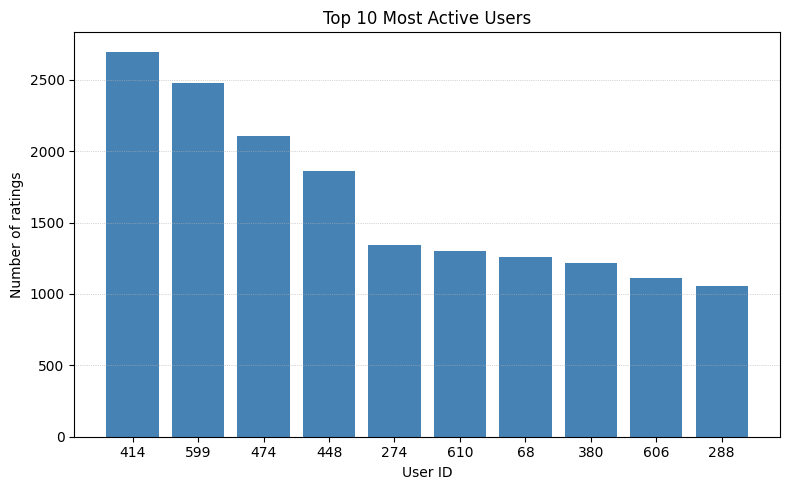

In [ ]:
# ----------------------------
# 1) Most active users
# ----------------------------
most_active = (
    ratings_df.groupby('userId')['rating']
    .count()
    .reset_index(name='ratings_count')
    .sort_values('ratings_count', ascending=False)
)
print("\nTop 10 most active users (userId -> ratings_count):")
print(most_active.head(10).to_string(index=False))

# Take top 10 most active users
top10_users = most_active.head(10)

# Bar chart
plt.figure(figsize=(8,5))
plt.bar(top10_users['userId'].astype(str), top10_users['ratings_count'], color='steelblue')
plt.xlabel("User ID")
plt.ylabel("Number of ratings")
plt.title("Top 10 Most Active Users")
plt.grid(axis='y', linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()

In [ ]:
# Pull tables to pandas
movies_df = duckdb.sql("SELECT * FROM movies").to_df()
ratings_df = duckdb.sql("SELECT * FROM ratings").to_df()

# Normalize column names in case (ml-latest-small uses movieId/userId)
# (your code used movieId/userId already — adapt if you have movie_id/user_id)
print("Loaded rows:", len(movies_df), "movies;", len(ratings_df), "ratings")

Loaded rows: 9742 movies; 100836 ratings


In [18]:
# explode genres (pandas)
genres_df = movies_df[['movieId', 'title', 'genres']].copy()
genres_df['genres_list'] = genres_df['genres'].str.split('|')
genres_exploded = genres_df.explode('genres_list').rename(columns={'genres_list': 'genre'})
genres_exploded = genres_exploded[~genres_exploded['genre'].isna()].reset_index(drop=True)

# join ratings -> compute per-genre stats
ratings_with_genres = ratings_df.merge(genres_exploded[['movieId', 'genre']], on='movieId', how='left')
genre_stats = (
    ratings_with_genres.groupby('genre')['rating']
    .agg(['mean','count'])
    .rename(columns={'mean':'avg_rating','count':'rating_count'})
    .reset_index()
    .sort_values('avg_rating', ascending=False)
)
print("\nTop-rated genres (by average rating) — full table head:")
print(genre_stats.head(20).to_string(index=False))

# Optional: show only genres with a minimum number of ratings for stability:
min_ratings_genre = 1000
stable_genres = genre_stats[genre_stats['rating_count'] >= min_ratings_genre].sort_values('avg_rating', ascending=False)
print(f"\nGenres with >= {min_ratings_genre} ratings (stable):")
print(stable_genres.to_string(index=False))


Top-rated genres (by average rating) — full table head:
             genre  avg_rating  rating_count
         Film-Noir    3.920115           870
               War    3.808294          4859
       Documentary    3.797785          1219
             Crime    3.658294         16681
             Drama    3.656184         41928
           Mystery    3.632460          7674
         Animation    3.629937          6988
              IMAX    3.618335          4145
           Western    3.583938          1930
           Musical    3.563678          4138
         Adventure    3.508609         24161
           Romance    3.506511         18124
          Thriller    3.493706         26452
           Fantasy    3.491001         11834
(no genres listed)    3.489362            47
            Sci-Fi    3.455721         17243
            Action    3.447984         30635
          Children    3.412956          9208
            Comedy    3.384721         39053
            Horror    3.258195          729

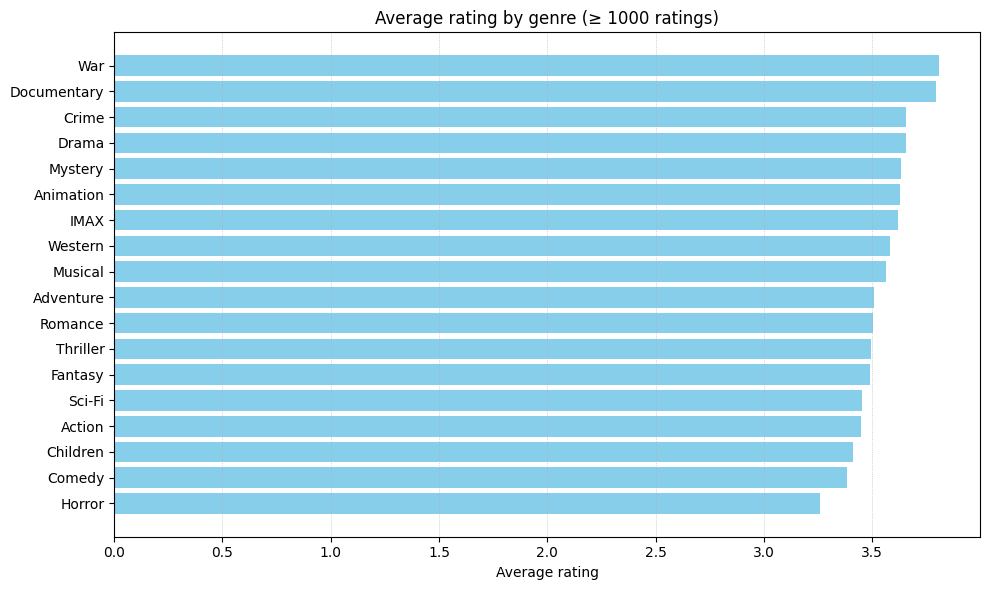

In [25]:
import matplotlib.pyplot as plt

# Bar chart of stable genres by average rating
plt.figure(figsize=(10,6))
plt.barh(stable_genres['genre'], stable_genres['avg_rating'], color='skyblue')
plt.xlabel("Average rating")
plt.title(f"Average rating by genre (≥ {min_ratings_genre} ratings)")
plt.gca().invert_yaxis()  # highest rating at top
plt.grid(axis='x', linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()

How have average movie ratings and rating activity evolved over time in the MovieLens dataset?


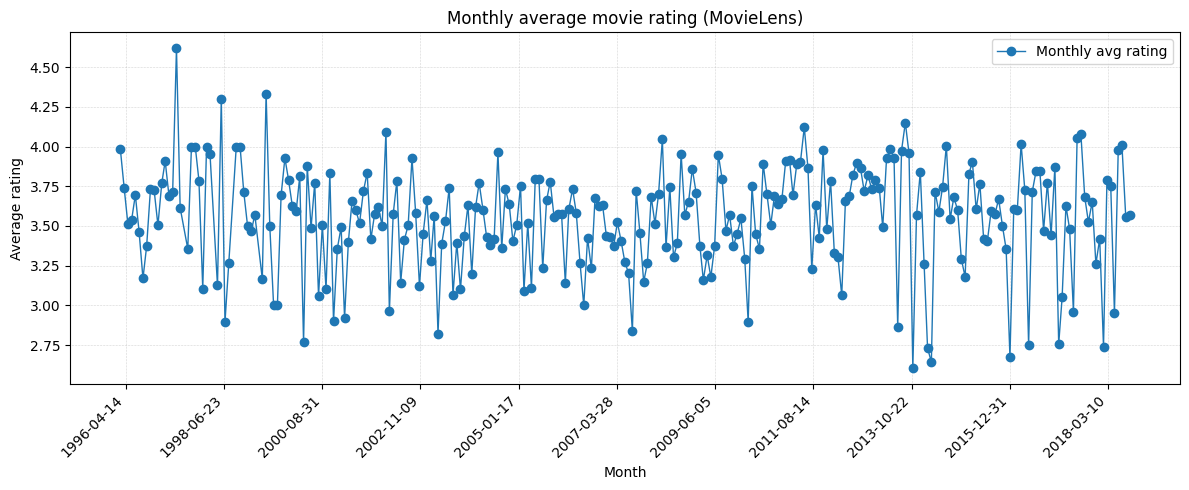

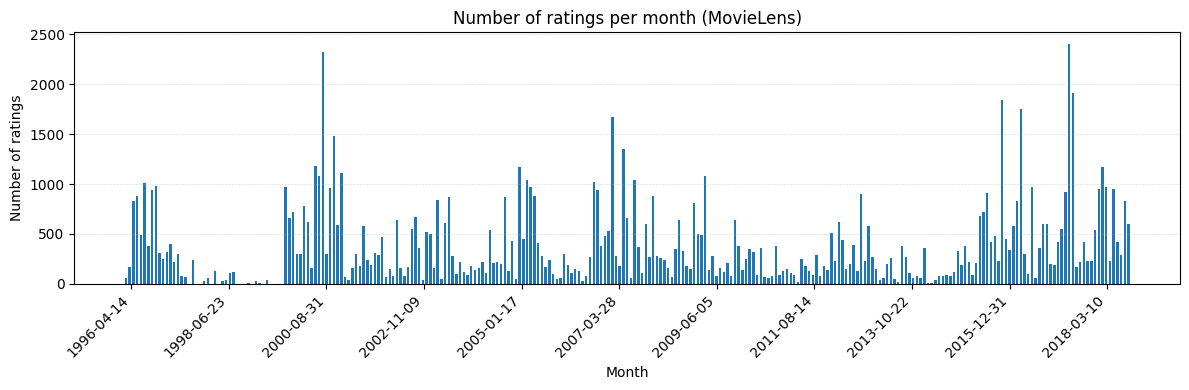


Recent monthly averages (last 12 months available in data):
month_start  avg_rating  rating_count  avg_rating_3m
 2017-10-01    3.524444           225       3.619800
 2017-11-01    3.652174           230       3.479271
 2017-12-01    3.261194           536       3.444281
 2018-01-01    3.419474           950       3.139778
 2018-02-01    2.738666          1169       3.314986
 2018-03-01    3.786818           971       3.425161
 2018-04-01    3.750000           230       3.496149
 2018-05-01    2.951630           951       3.560448
 2018-06-01    3.979714           419       3.647194
 2018-07-01    4.010239           293       3.849238
 2018-08-01    3.557762           831       3.712236
 2018-09-01    3.568709           604       3.563235


In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import os
# ---- Prepare time columns ----
# MovieLens timestamps are unix seconds
ratings_df['ts'] = pd.to_datetime(ratings_df['timestamp'], unit='s', errors='coerce')
# Drop any rows with bad timestamps (safety)
ratings_df = ratings_df.dropna(subset=['ts']).copy()

# Year-month string (easier to display) and an actual month-start datetime for plotting
ratings_df['year_month'] = ratings_df['ts'].dt.to_period('M').astype(str)
ratings_df['month_start'] = ratings_df['ts'].values.astype('datetime64[M]')  # first day of month

# ---- Aggregate: monthly mean rating and count ----
time_trend = (
    ratings_df
    .groupby('month_start')['rating']
    .agg(avg_rating='mean', rating_count='count')
    .reset_index()
    .sort_values('month_start')
)

# Optional: add a rolling average of avg_rating to smooth short-term noise (3-month window)
time_trend['avg_rating_3m'] = time_trend['avg_rating'].rolling(window=3, min_periods=1, center=True).mean()

# ---- Plot 1: Monthly average rating (line only, no rolling average) ----
fig1, ax1 = plt.subplots(figsize=(12, 5))
ax1.plot(
    time_trend['month_start'],
    time_trend['avg_rating'],
    marker='o',
    linewidth=1,
    label='Monthly avg rating'
)
ax1.set_title('Monthly average movie rating (MovieLens)')
ax1.set_xlabel('Month')
ax1.set_ylabel('Average rating')
ax1.xaxis.set_major_locator(MaxNLocator(nbins=12))  # keep x-axis reasonably spaced
plt.xticks(rotation=45, ha='right')
ax1.grid(True, linestyle=':', linewidth=0.4)
ax1.legend()
plt.tight_layout()
plt.show()

# ---- Plot 2: Monthly rating counts (bar) ----
fig2, ax2 = plt.subplots(figsize=(12, 4))
ax2.bar(time_trend['month_start'], time_trend['rating_count'], width=20)  # width in days approx
ax2.set_title('Number of ratings per month (MovieLens)')
ax2.set_xlabel('Month')
ax2.set_ylabel('Number of ratings')
ax2.xaxis.set_major_locator(MaxNLocator(nbins=12))
plt.xticks(rotation=45, ha='right')
ax2.grid(axis='y', linestyle=':', linewidth=0.4)
plt.tight_layout()
plt.show()

# ---- Quick textual summary printed for context ----
print("\nRecent monthly averages (last 12 months available in data):")
print(time_trend.tail(12).to_string(index=False))


In [20]:
# ----------------------------
# 4) Which movies have the most ratings?
# ----------------------------
movie_stats = (
    ratings_df.groupby('movieId')['rating']
    .agg(['mean','count'])
    .rename(columns={'mean':'avg_rating','count':'rating_count'})
    .reset_index()
)
movies_with_stats = movie_stats.merge(movies_df[['movieId','title']], on='movieId', how='left')
top_by_count = movies_with_stats.sort_values('rating_count', ascending=False).head(20)
print("\nTop 10 movies by number of ratings (title -> count, avg_rating):")
print(top_by_count[['title','rating_count','avg_rating']].head(10).to_string(index=False))



Top 10 movies by number of ratings (title -> count, avg_rating):
                                    title  rating_count  avg_rating
                      Forrest Gump (1994)           329    4.164134
         Shawshank Redemption, The (1994)           317    4.429022
                      Pulp Fiction (1994)           307    4.197068
         Silence of the Lambs, The (1991)           279    4.161290
                       Matrix, The (1999)           278    4.192446
Star Wars: Episode IV - A New Hope (1977)           251    4.231076
                     Jurassic Park (1993)           238    3.750000
                        Braveheart (1995)           237    4.031646
        Terminator 2: Judgment Day (1991)           224    3.970982
                  Schindler's List (1993)           220    4.225000


In [21]:
# ----------------------------
# 5) Correlation between popularity and average rating
# ----------------------------
# Popularity measure = rating_count; compute Pearson correlation with avg_rating
corr = movies_with_stats['rating_count'].corr(movies_with_stats['avg_rating'])
print(f"\nPearson correlation between number of ratings and average rating: {corr:.4f}")

# Optionally compute correlation only for movies with >= N ratings (to avoid very-low-count noise)
min_ratings_for_corr = 30
subset = movies_with_stats[movies_with_stats['rating_count'] >= min_ratings_for_corr]
corr_stable = subset['rating_count'].corr(subset['avg_rating'])
print(f"Correlation (movies with >= {min_ratings_for_corr} ratings): {corr_stable:.4f}")



Pearson correlation between number of ratings and average rating: 0.1273
Correlation (movies with >= 30 ratings): 0.3180


Most common Tags 

In [14]:
tags_df = duckdb.sql("SELECT * FROM tags").to_df()

In [15]:
# Get the count of each unique tag
tag_counts = tags_df['tag'].value_counts()

# Display the top 20 most common tags
print("Top 20 Most Common Tags:")
print("-" * 40)
print(tag_counts.head(20))

Top 20 Most Common Tags:
----------------------------------------
tag
In Netflix queue      131
atmospheric            36
thought-provoking      24
superhero              24
funny                  23
surreal                23
Disney                 23
religion               22
sci-fi                 21
quirky                 21
dark comedy            21
psychology             21
suspense               20
twist ending           19
visually appealing     19
crime                  19
politics               18
mental illness         16
music                  16
time travel            16
Name: count, dtype: int64


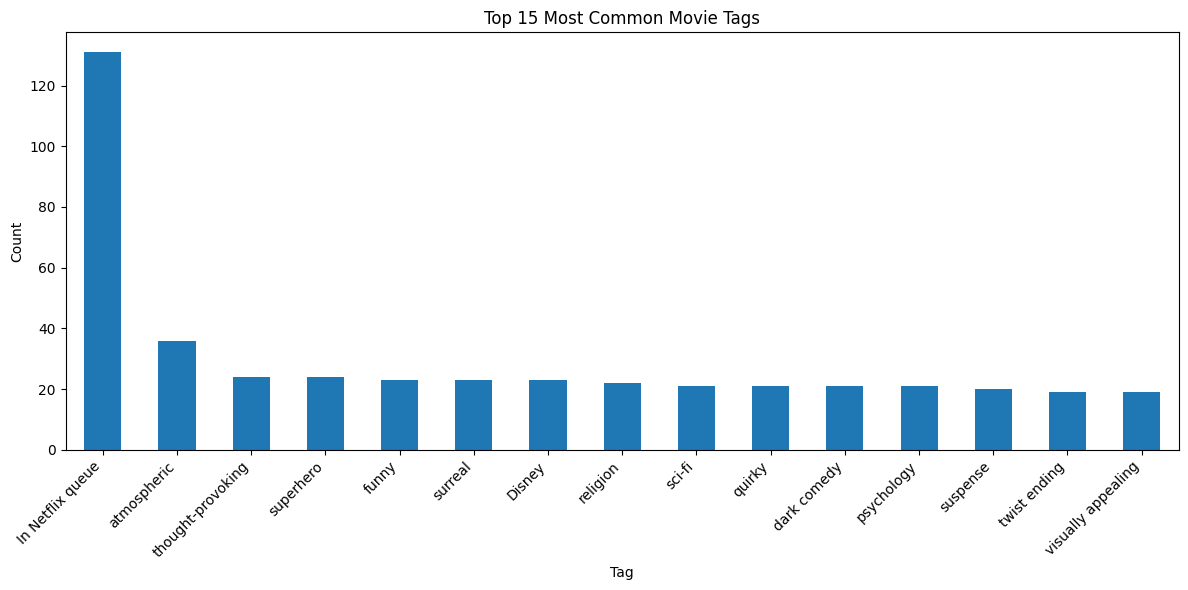

In [16]:
# Create a bar plot of the top 15 tags
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
tag_counts.head(15).plot(kind='bar')
plt.title('Top 15 Most Common Movie Tags')
plt.xlabel('Tag')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Quais as Tags que os Melhores e Piores filmes têm 

In [17]:
# Read the CSV files
import pandas as pd

# Reading the files
movies_df = duckdb.sql("SELECT * FROM movies").to_df()
ratings_df = duckdb.sql("SELECT * FROM ratings").to_df()
#tags_df = pd.read_csv('c:/Users/marti/OneDrive/Documentos/IMS_EDSA/B.D.F/ml-latest-small/tags.csv')

# Calculate average rating for each movie
movie_ratings = ratings_df.groupby('movieId').agg({
    'rating': ['mean', 'count']
}).reset_index()

# Flatten column names
movie_ratings.columns = ['movieId', 'avg_rating', 'num_ratings']

# Filter movies with at least 50 ratings to get more reliable results
min_ratings = 50
filtered_ratings = movie_ratings[movie_ratings['num_ratings'] >= min_ratings]

# Join with movies data
movie_analysis = filtered_ratings.merge(movies_df, on='movieId', how='inner')

# Get top 10 and bottom 10 movies
top_10_movies = movie_analysis.nlargest(10, 'avg_rating')
bottom_10_movies = movie_analysis.nsmallest(10, 'avg_rating')

print("Top 10 Highest Rated Movies:")
print("-" * 100)
print(top_10_movies[['title', 'avg_rating', 'num_ratings']].to_string(index=False))
print("\nBottom 10 Lowest Rated Movies:")
print("-" * 100)
print(bottom_10_movies[['title', 'avg_rating', 'num_ratings']].to_string(index=False))

Top 10 Highest Rated Movies:
----------------------------------------------------------------------------------------------------
                                                                      title  avg_rating  num_ratings
                                           Shawshank Redemption, The (1994)    4.429022          317
                                                      Godfather, The (1972)    4.289062          192
                                                          Fight Club (1999)    4.272936          218
                                                      Cool Hand Luke (1967)    4.271930           57
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)    4.268041           97
                                                         Rear Window (1954)    4.261905           84
                                             Godfather: Part II, The (1974)    4.259690          129
                                                       Departe

In [18]:
# Function to get tags for a movie
def get_movie_tags(movie_id):
    movie_tags = tags_df[tags_df['movieId'] == movie_id]['tag'].tolist()
    return ', '.join(movie_tags) if movie_tags else 'No tags'

print("Tags for Top 10 Movies:")
print("-" * 100)
for _, movie in top_10_movies.iterrows():
    print(f"\nMovie: {movie['title']}")
    print(f"Rating: {movie['avg_rating']:.2f} (from {movie['num_ratings']} ratings)")
    print(f"Tags: {get_movie_tags(movie['movieId'])}")

print("\n\nTags for Bottom 10 Movies:")
print("-" * 100)
for _, movie in bottom_10_movies.iterrows():
    print(f"\nMovie: {movie['title']}")
    print(f"Rating: {movie['avg_rating']:.2f} (from {movie['num_ratings']} ratings)")
    print(f"Tags: {get_movie_tags(movie['movieId'])}")

Tags for Top 10 Movies:
----------------------------------------------------------------------------------------------------

Movie: Shawshank Redemption, The (1994)
Rating: 4.43 (from 317 ratings)
Tags: prison, Stephen King, wrongful imprisonment, Morgan Freeman

Movie: Godfather, The (1972)
Rating: 4.29 (from 192 ratings)
Tags: Mafia

Movie: Fight Club (1999)
Rating: 4.27 (from 218 ratings)
Tags: dark comedy, psychology, thought-provoking, twist ending, dark comedy, violence, action, atmospheric, based on a book, Brad Pitt, challenging, Chuck Palahniuk, classic, clever, complicated, consumerism, crime, dark, dark comedy, David Fincher, disturbing, double life, Edward Norton, fighting, great acting, helena bonham carter, imaginary friend, imdb top 250, mental illness, mind-blowing, mindfuck, narrated, Nudity (Topless), Palahnuik, philosophical, philosophy, postmodern, powerful ending, psychological, psychological thriller, psychology, quirky, satirical, schizophrenia, social commentar

Podemos concluir que quanto melhor os filmes são, mais vontade os individuos têm de comentar positivamente (ou negativamente). O oposto não acontece, visto que os movies com menos ratings não têm tags.

In [23]:
# Transform timestamps to dates
from datetime import datetime

# Transform timestamps in ratings DataFrame
ratings_df['date'] = ratings_df['timestamp'].apply(lambda x: datetime.fromtimestamp(x).strftime('%d-%m-%Y %H:%M:%S'))
print("\nRatings DataFrame with converted timestamps:")
print("-" * 80)
print(ratings_df[['userId', 'movieId', 'rating', 'date']].head())

# Transform timestamps in tags DataFrame
tags_df['date'] = tags_df['timestamp'].apply(lambda x: datetime.fromtimestamp(x).strftime('%d-%m-%Y %H:%M:%S'))
print("\nTags DataFrame with converted timestamps:")
print("-" * 80)
print(tags_df[['userId', 'movieId', 'tag', 'date']].head())


Ratings DataFrame with converted timestamps:
--------------------------------------------------------------------------------
   userId  movieId  rating                 date
0       1        1     4.0  30-07-2000 19:45:03
1       1        3     4.0  30-07-2000 19:20:47
2       1        6     4.0  30-07-2000 19:37:04
3       1       47     5.0  30-07-2000 20:03:35
4       1       50     5.0  30-07-2000 19:48:51

Tags DataFrame with converted timestamps:
--------------------------------------------------------------------------------
   userId  movieId              tag                 date
0       2    60756            funny  24-10-2015 20:29:54
1       2    60756  Highly quotable  24-10-2015 20:29:56
2       2    60756     will ferrell  24-10-2015 20:29:52
3       2    89774     Boxing story  24-10-2015 20:33:27
4       2    89774              MMA  24-10-2015 20:33:20


In [27]:
# Display date range statistics
print("\nDate Range Statistics:")
print("-" * 80)

print("Ratings Date Range:")
print(f"Earliest rating: {ratings_df['date'].min()}")
print(f"Latest rating: {ratings_df['date'].max()}")
#print(f"Total time span: {ratings_df['date'].max() - ratings_df['date'].min()}")

print("\nTags Date Range:")
print(f"Earliest tag: {tags_df['date'].min()}")
print(f"Latest tag: {tags_df['date'].max()}")
#print(f"Total time span: {tags_df['date'].max() - tags_df['date'].min()}")



Date Range Statistics:
--------------------------------------------------------------------------------
Ratings Date Range:
Earliest rating: 01-01-1997 10:20:51
Latest rating: 31-12-2016 21:57:02

Tags Date Range:
Earliest tag: 01-02-2006 14:30:06
Latest tag: 31-07-2010 21:29:48


## Analysis of Movies by Rating Timeline

In [30]:
# Get first and last rated movies
earliest_rating = ratings_df.sort_values('date').iloc[0]
latest_rating = ratings_df.sort_values('date').iloc[-1]

# Get movie details for these ratings
earliest_movie = movies_df[movies_df['movieId'] == earliest_rating['movieId']].iloc[0]
latest_movie = movies_df[movies_df['movieId'] == latest_rating['movieId']].iloc[0]

print("First Rating in the Dataset:")
print("-" * 80)
print(f"Date: {earliest_rating['date']}")
print(f"Movie: {earliest_movie['title']}")
print(f"Rating given: {earliest_rating['rating']}")
print(f"User ID: {earliest_rating['userId']}")

print("\nLast Rating in the Dataset:")
print("-" * 80)
print(f"Date: {latest_rating['date']}")
print(f"Movie: {latest_movie['title']}")
print(f"Rating given: {latest_rating['rating']}")
print(f"User ID: {latest_rating['userId']}")

# Get some statistics about movies rated in the first and last month
first_month = ratings_df['date'].min()[:7]  # Get YYYY-MM of first month
last_month = ratings_df['date'].max()[:7]   # Get YYYY-MM of last month

first_month_ratings = ratings_df[ratings_df['date'].str.startswith(first_month)]
last_month_ratings = ratings_df[ratings_df['date'].str.startswith(last_month)]

print(f"\nStatistics for First Month ({first_month}):")
print("-" * 80)
print(f"Number of ratings: {len(first_month_ratings)}")
print(f"Number of unique movies rated: {first_month_ratings['movieId'].nunique()}")
print(f"Number of unique users: {first_month_ratings['userId'].nunique()}")
print(f"Average rating: {first_month_ratings['rating'].mean():.2f}")

print(f"\nStatistics for Last Month ({last_month}):")
print("-" * 80)
print(f"Number of ratings: {len(last_month_ratings)}")
print(f"Number of unique movies rated: {last_month_ratings['movieId'].nunique()}")
print(f"Number of unique users: {last_month_ratings['userId'].nunique()}")
print(f"Average rating: {last_month_ratings['rating'].mean():.2f}")

First Rating in the Dataset:
--------------------------------------------------------------------------------
Date: 01-01-1997 10:20:51
Movie: Broken Arrow (1996)
Rating given: 3.0
User ID: 179

Last Rating in the Dataset:
--------------------------------------------------------------------------------
Date: 31-12-2016 21:57:02
Movie: Rock the Kasbah (2015)
Rating given: 2.0
User ID: 448

Statistics for First Month (01-01-1):
--------------------------------------------------------------------------------
Number of ratings: 29
Number of unique movies rated: 29
Number of unique users: 1
Average rating: 3.62

Statistics for Last Month (31-12-2):
--------------------------------------------------------------------------------
Number of ratings: 148
Number of unique movies rated: 148
Number of unique users: 12
Average rating: 3.11


,userId,movieId,rating,timestamp,date,year
0,1,1,4.0,964982703,30-07-2000 19:45:03,2000
1,1,3,4.0,964981247,30-07-2000 19:20:47,2000
2,1,6,4.0,964982224,30-07-2000 19:37:04,2000
3,1,47,5.0,964983815,30-07-2000 20:03:35,2000
4,1,50,5.0,964982931,30-07-2000 19:48:51,2000


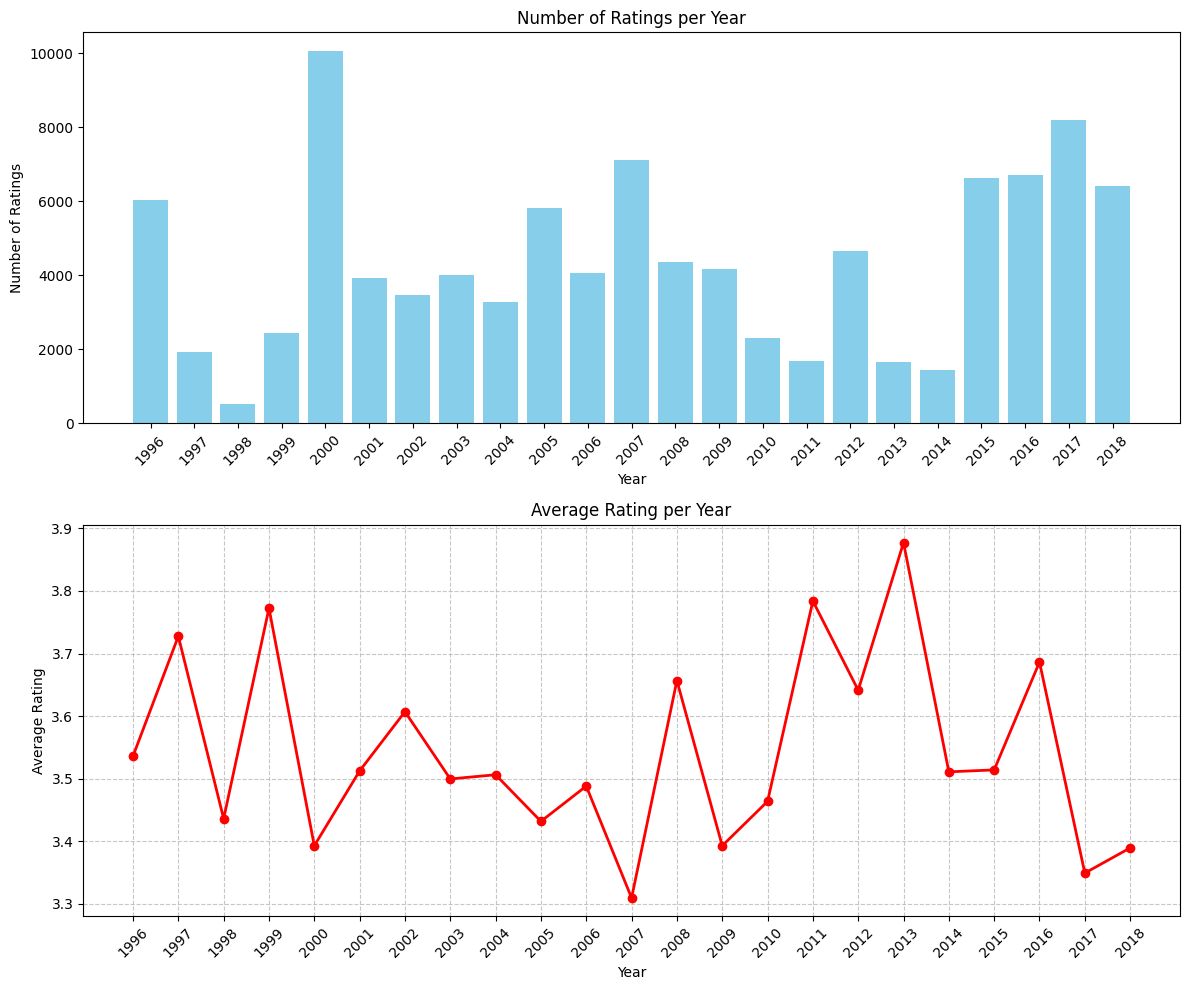


Yearly Statistics Summary:
--------------------------------------------------------------------------------
year  num_ratings  avg_rating  unique_movies  unique_users
1996         6040    3.535927            607            97
1997         1916    3.727557            649            33
1998          507    3.435897            333            11
1999         2439    3.772448           1013            27
2000        10061    3.392506           2380            56
2001         3922    3.512239           1831            38
2002         3478    3.606958           1713            25
2003         4014    3.499377           2078            31
2004         3279    3.506099           1821            24
2005         5813    3.431533           2380            43
2006         4059    3.487928           1571            43
2007         7114    3.309039           2881            46
2008         4351    3.656746           1879            41
2009         4158    3.392496           2106            45
2010  

In [33]:
# Create a year-based analysis
import matplotlib.pyplot as plt

# Extract year from date
ratings_df['year'] = ratings_df['date'].str[6:10]
display(ratings_df.head())

# Get yearly statistics
yearly_stats = ratings_df.groupby('year').agg({
    'rating': ['count', 'mean'],
    'movieId': 'nunique',
    'userId': 'nunique'
}).reset_index()

yearly_stats.columns = ['year', 'num_ratings', 'avg_rating', 'unique_movies', 'unique_users']

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot number of ratings per year
ax1.bar(yearly_stats['year'], yearly_stats['num_ratings'], color='skyblue')
ax1.set_title('Number of Ratings per Year')
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Ratings')
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

# Plot average rating per year
ax2.plot(yearly_stats['year'], yearly_stats['avg_rating'], marker='o', color='red', linewidth=2)
ax2.set_title('Average Rating per Year')
ax2.set_xlabel('Year')
ax2.set_ylabel('Average Rating')
ax2.grid(True, linestyle='--', alpha=0.7)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nYearly Statistics Summary:")
print("-" * 80)
print(yearly_stats.to_string(index=False))